<a href="https://colab.research.google.com/github/dsaragih/RL-games/blob/main/N_tictactoe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install tensordict==0.2.0
pip install torchrl==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.4/985.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.3 MB/s eta 0:00:00


In [ ]:
# Imports
import gym
from gym import spaces
import pygame
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [ ]:
# @title Environment Class
import gym
from gym import spaces
import pygame
import numpy as np


class NTicTacToe(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=3, starting_player=1):
        # The size also determines the number in a row needed to win.
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are a box of size x size, where each entry is either
        # 0 (empty), 1 (cross), or -1 (circle)
        self.observation_space = spaces.Box(-1, 1, shape=(size, size), dtype=int)

        # We have size x size possible actions, each of which is a tuple of
        # (row, column) of the grid
        self.action_space = spaces.Discrete(size * size)
        self.starting_player = starting_player
        self.player = starting_player # 1 for crosses, -1 for circles
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
    def _action_to_xy(self, action):
        # Convert action to (x, y) coordinates
        return action // self.size, action % self.size

    def _get_obs(self):
        return self.board.copy()

    def _get_info(self):
        # Return number of rows that are not -1
        return {
            "player": self.player,
            "n_crosses": np.count_nonzero(self.board == 1),
            "n_circles": np.count_nonzero(self.board == -1),
        }

    def _check_win(self):
        # Check if the current player has {self.size} in a row
        # First check rows
        for row in range(self.size):
            if np.all(self.board[row, :] == self.player):
                return True

        # Now check columns
        for col in range(self.size):
            if np.all(self.board[:, col] == self.player):
                return True

        # Now check diagonals
        if np.all(np.diag(self.board) == self.player):
            return True
        if np.all(np.diag(np.fliplr(self.board)) == self.player):
            return True

        return False


    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Reset the crosses and circles locations
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.player = self.starting_player

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        assert self.action_space.contains(action)

        action = self._action_to_xy(action)
        # Check action validity
        # If invalid action, lose the game
        flag = 0 if self.board[action[0], action[1]] == 0 else 1

        # Place the cross/circle
        if not flag:
          self.board[action[0], action[1]] = self.player

        # An episode is done iff the current player has won or the board is full
        terminated = self._check_win() or np.all(self.board != 0) or flag

        # Reward 1, 0, -1 for win, draw, loss
        if self._check_win() and self.player == self.starting_player:
            reward = 1
        elif (self._check_win() and self.player != self.starting_player):
            reward = -1
        else:
            reward = 0

        if flag:
          reward = -self.player

        self.player = -self.player

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw crosses and circles
        pad = pix_square_size / 10
        width = 3
        for row in range(self.size):
            for col in range(self.size):
                if self.board[row, col] == 1:
                    pygame.draw.line(
                        canvas,
                        (0, 0, 0),
                        (pix_square_size * col + pad, pix_square_size * row + pad),
                        (
                            pix_square_size * (col + 1) - pad,
                            pix_square_size * (row + 1) - pad,
                        ),
                        width=width,
                    )
                    pygame.draw.line(
                        canvas,
                        (0, 0, 0),
                        (pix_square_size * (col + 1) - pad, pix_square_size * row + pad),
                        (pix_square_size * col + pad, pix_square_size * (row + 1) - pad),
                        width=width,
                    )
                elif self.board[row, col] == -1:
                    pygame.draw.circle(
                        canvas,
                        (0, 0, 0),
                        (
                            int(pix_square_size * (col + 0.5)),
                            int(pix_square_size * (row + 0.5)),
                        ),
                        int(pix_square_size / 2 - pad),
                        width=width,
                    )

        # Finally, add some gridlines
        # Note x: 0 is the leftmost, y: 0 is the topmost
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [ ]:
class PlayerNet(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    h, w = input_dim

    # NOTE: Use of CNN may be a bit much
    # self.online = self._build_cnn(h, w, output_dim)
    # self.target = self._build_cnn(h, w, output_dim)
    self.online = self._build_dense(h, w, output_dim)
    self.target = self._build_dense(h, w, output_dim)

    self.target.load_state_dict(self.online.state_dict())

    for p in self.target.parameters():
      p.requires_grad = False

  def forward(self, input, model):
    if model == "online":
      return self.online(input)
    elif model == "target":
      return self.target(input)

  def _build_cnn(self, h, w, output_dim):
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear((h-4)** 2 * 64, 512),
        nn.ReLU(),
        nn.Linear(512, output_dim),
    )

  def _build_dense(self, h, w, output_dim):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(h * w, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim)
    )

In [ ]:
# Model class
class Player:
  def __init__(self, player, state_dim, action_dim, save_dir):
    # player = 1 (X) or -1 (O)
    # state_dim = (size, size)
    # action_dim = size * size
    self.state_dim = state_dim
    self.action_dim = action_dim # (x, y) to place the X or O
    self.player = player
    self.save_dir = save_dir

    self.exp_rate = 1
    self.exp_rate_decay = 0.99975
    self.exp_rate_min = 0.2

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.net = PlayerNet(self.state_dim, self.action_dim).float()
    self.net = self.net.to(device=self.device)

    self.curr_step = 0
    self.save_every = 5e4

    self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000,
                                         device=torch.device('cpu')))
    self.batch_size = 8

    self.gamma = 0.9
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0025)
    self.loss_fn = torch.nn.SmoothL1Loss()

    self.burnin = 1e2  # min. experiences before training
    self.learn_every = 1  # no. of experiences between updates to Q_online
    self.sync_every = 1e2  # no. of experiences between Q_target & Q_online sync

  def act(self, state):
    # Explore
    if np.random.rand() < self.exp_rate:
      s_state = state.reshape(-1)
      action_idx = np.random.choice(np.where(s_state == 0)[0])
      from_model = False
    else:
      # Because of some technicality with FrameStack, state may be a tuple
      # instead of a LazyWrapper, so we check for this.
      state = state.__array__()
      state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
      action_values = self.net(state, "online")

      # s_state = state.reshape(-1)
      # mask = (s_state != 0).unsqueeze(0)
      # # Apply the mask to action_values by setting masked elements to a large negative number
      # masked_values = action_values - mask * float('inf')

      # Take the argmax over the masked values
      s_state = state.reshape(-1)
      avail_mask = (s_state == 0)
      # print("Avail mask ", avail_mask.shape)
      # Get the indices where s_state == 0
      valid_indices = torch.nonzero(avail_mask, as_tuple=False).squeeze(0)
      # print("Valid indices ", valid_indices.shape)
      # if valid_indices.nelement() == 1:
      #   print(avail_mask.cpu().numpy())
      #   print(s_state.cpu().numpy())
      # Index into action_values using the valid indices
      valid_action_values = action_values[:, valid_indices]
      # print(valid_action_values.shape)
      # Take the argmax over the valid action values
      argmax_valid = torch.argmax(valid_action_values, dim=1).item()

      # Map the argmax index back to the original indices
      action_idx = valid_indices[argmax_valid].item()
      from_model = True

    self.exp_rate *= self.exp_rate_decay
    self.exp_rate = max(self.exp_rate_min, self.exp_rate)

    self.curr_step += 1
    return action_idx, from_model

  def cache(self, state, next_state, action, reward, done):
    # Preprocess as before and note that we convert to array before tensor-ing
    def first_if_tuple(x):
      return x[0] if isinstance(x, tuple) else x

    state = first_if_tuple(state).__array__() # size x size
    next_state = first_if_tuple(state).__array__()

    state = torch.tensor(state)
    next_state = torch.tensor(next_state)
    action = torch.tensor([action])
    reward = torch.tensor([reward])
    done = torch.tensor([done])

    # Leave batch size unspecified (later fixed during sampling)
    self.memory.add(TensorDict({
        'state': state,
        'next_state': next_state,
        'action': action,
        'reward': reward,
        'done': done
    }, batch_size=[]))

  def recall(self):
    batch = self.memory.sample(self.batch_size).to(self.device)
    state, next_state, action, reward, done = \
     (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
    return state, next_state, action, reward, done

  def td_estimate(self, state, action):
    current_Q = self.net(state, model="online")
    # print(current_Q.shape)
    # print("State: ", state)
    # print("Action: ", action)
    action_clone = action.contiguous()
    # print("Action print: ", action_clone)
    current_Q = current_Q[np.arange(0, self.batch_size), action_clone]
    # print(current_Q.shape)
    return current_Q

  @torch.no_grad()
  def td_target(self, reward, next_state, done):
    next_state_Q = self.net(next_state, model="online")
    max_action = torch.argmax(next_state_Q, dim=1)
    next_Q = self.net(next_state, model="target")[
        np.arange(0, self.batch_size), max_action
    ]

    return (reward + (1 - done.float()) * (self.gamma * next_Q)).float()

  def update_Q_online(self, td_e, td_t):
    loss = self.loss_fn(td_e, td_t)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()

  def sync_Q_target(self):
    self.net.target.load_state_dict(self.net.online.state_dict())

  def learn(self):
    if self.curr_step % self.sync_every == 0:
      self.sync_Q_target()
    if self.curr_step % self.save_every == 0:
      self.save()
    if self.curr_step % self.learn_every != 0:
      return None, None
    if self.curr_step < self.burnin:
      return None, None

    # Sample
    state, next_state, action, reward, done = self.recall()
    if state is None or action is None:
      return None, None

    # Get td_e, td_t
    td_e = self.td_estimate(state, action)
    td_t = self.td_target(reward, next_state, done)

    # Update params
    loss = self.update_Q_online(td_e, td_t)

    return (td_e.mean().item()), loss


  def save(self):
    pre = "X" if self.player == 1 else "O"
    save_path = (
        self.save_dir / f"{pre}_player_net_{int(self.curr_step // self.save_every)}.chkpt"
    )
    torch.save(
        dict(model=self.net.state_dict(), exploration_rate=self.exp_rate),
        save_path,
    )
    print(f"PlayerNet saved to {save_path} at step {self.curr_step}")

In [ ]:
# @title Logger
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir, pre="W"):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / f"{pre}_reward_plot.jpg"
        self.ep_lengths_plot = save_dir / f"{pre}_length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / f"{pre}_loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / f"{pre}_q_plot.jpg"
        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)

        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        look_behind = 50
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-look_behind:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-look_behind:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-look_behind:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-look_behind:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f'{metric}_plot'))

Using CUDA: True

Episode 0 - Step 24 - Epsilon 0.9940172184164668 - Mean Reward 1.0 - Mean Length 24.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.021 - Time 2023-12-28T09:06:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 20 - Step 482 - Epsilon 0.8864637326590109 - Mean Reward 0.524 - Mean Length 22.952 - Mean Loss 0.009 - Mean Q Value 0.095 - Time Delta 2.352 - Time 2023-12-28T09:06:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 40 - Step 939 - Epsilon 0.7907453094073678 - Mean Reward 0.537 - Mean Length 22.902 - Mean Loss 0.008 - Mean Q Value 0.151 - Time Delta 2.631 - Time 2023-12-28T09:06:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 60 - Step 1424 - Epsilon 0.7004414447013069 - Mean Reward 0.44 - Mean Length 23.72 - Mean Loss 0.008 - Mean Q Value 0.218 - Time Delta 2.794 - Time 2023-12-28T09:06:43


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 80 - Step 1887 - Epsilon 0.6238726745804217 - Mean Reward 0.54 - Mean Length 23.3 - Mean Loss 0.008 - Mean Q Value 0.244 - Time Delta 3.6 - Time 2023-12-28T09:06:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 100 - Step 2362 - Epsilon 0.5540092892343887 - Mean Reward 0.5 - Mean Length 23.46 - Mean Loss 0.007 - Mean Q Value 0.24 - Time Delta 2.815 - Time 2023-12-28T09:06:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 120 - Step 2840 - Epsilon 0.49160055870169767 - Mean Reward 0.38 - Mean Length 23.82 - Mean Loss 0.008 - Mean Q Value 0.231 - Time Delta 2.815 - Time 2023-12-28T09:06:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 140 - Step 3319 - Epsilon 0.4361130692815377 - Mean Reward 0.32 - Mean Length 23.76 - Mean Loss 0.008 - Mean Q Value 0.227 - Time Delta 2.858 - Time 2023-12-28T09:06:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 160 - Step 3801 - Epsilon 0.3865984192566904 - Mean Reward 0.28 - Mean Length 23.84 - Mean Loss 0.007 - Mean Q Value 0.224 - Time Delta 3.403 - Time 2023-12-28T09:06:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 180 - Step 4255 - Epsilon 0.34511313405284677 - Mean Reward 0.34 - Mean Length 23.58 - Mean Loss 0.007 - Mean Q Value 0.221 - Time Delta 2.925 - Time 2023-12-28T09:07:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 200 - Step 4737 - Epsilon 0.3059302770021368 - Mean Reward 0.42 - Mean Length 23.36 - Mean Loss 0.007 - Mean Q Value 0.218 - Time Delta 2.877 - Time 2023-12-28T09:07:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 220 - Step 5216 - Epsilon 0.271399594097109 - Mean Reward 0.38 - Mean Length 23.72 - Mean Loss 0.007 - Mean Q Value 0.217 - Time Delta 2.876 - Time 2023-12-28T09:07:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 240 - Step 5682 - Epsilon 0.24155028886560934 - Mean Reward 0.42 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 3.192 - Time 2023-12-28T09:07:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 260 - Step 6168 - Epsilon 0.21391152540568517 - Mean Reward 0.4 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 3.476 - Time 2023-12-28T09:07:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 280 - Step 6657 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 2.987 - Time 2023-12-28T09:07:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 300 - Step 7142 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.38 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.022 - Time 2023-12-28T09:07:20


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 320 - Step 7637 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.42 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 3.35 - Time 2023-12-28T09:07:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 340 - Step 8106 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.238 - Time Delta 3.255 - Time 2023-12-28T09:07:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 360 - Step 8585 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.86 - Mean Loss 0.006 - Mean Q Value 0.249 - Time Delta 2.894 - Time 2023-12-28T09:07:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 380 - Step 9067 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.86 - Mean Loss 0.006 - Mean Q Value 0.265 - Time Delta 2.95 - Time 2023-12-28T09:07:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 400 - Step 9547 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.02 - Mean Loss 0.006 - Mean Q Value 0.268 - Time Delta 3.19 - Time 2023-12-28T09:07:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 420 - Step 10021 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.264 - Time Delta 3.36 - Time 2023-12-28T09:07:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 440 - Step 10490 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.74 - Mean Loss 0.007 - Mean Q Value 0.261 - Time Delta 3.036 - Time 2023-12-28T09:07:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 460 - Step 10963 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.5 - Mean Loss 0.006 - Mean Q Value 0.262 - Time Delta 2.846 - Time 2023-12-28T09:07:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 480 - Step 11424 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.262 - Time Delta 2.979 - Time 2023-12-28T09:07:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 500 - Step 11910 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.88 - Mean Loss 0.006 - Mean Q Value 0.267 - Time Delta 3.551 - Time 2023-12-28T09:07:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 520 - Step 12389 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.9 - Mean Loss 0.009 - Mean Q Value 0.277 - Time Delta 2.933 - Time 2023-12-28T09:07:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 540 - Step 12875 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.22 - Mean Loss 0.01 - Mean Q Value 0.268 - Time Delta 2.962 - Time 2023-12-28T09:07:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 560 - Step 13341 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.9 - Mean Loss 0.009 - Mean Q Value 0.253 - Time Delta 2.832 - Time 2023-12-28T09:08:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 580 - Step 13818 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.66 - Mean Loss 0.009 - Mean Q Value 0.255 - Time Delta 3.601 - Time 2023-12-28T09:08:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 600 - Step 14299 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.96 - Mean Loss 0.01 - Mean Q Value 0.263 - Time Delta 2.87 - Time 2023-12-28T09:08:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 620 - Step 14775 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.98 - Mean Loss 0.01 - Mean Q Value 0.271 - Time Delta 3.082 - Time 2023-12-28T09:08:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 640 - Step 15256 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.9 - Mean Loss 0.01 - Mean Q Value 0.262 - Time Delta 3.327 - Time 2023-12-28T09:08:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 660 - Step 15725 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.84 - Mean Loss 0.008 - Mean Q Value 0.244 - Time Delta 3.523 - Time 2023-12-28T09:08:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 680 - Step 16193 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.231 - Time Delta 2.972 - Time 2023-12-28T09:08:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 700 - Step 16671 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 3.491 - Time 2023-12-28T09:08:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 720 - Step 17166 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.233 - Time Delta 3.17 - Time 2023-12-28T09:08:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 740 - Step 17636 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.245 - Time Delta 3.472 - Time 2023-12-28T09:08:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 760 - Step 18102 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.258 - Time Delta 2.841 - Time 2023-12-28T09:08:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 780 - Step 18587 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.263 - Time Delta 2.942 - Time 2023-12-28T09:08:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 800 - Step 19060 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.254 - Time Delta 3.195 - Time 2023-12-28T09:08:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 820 - Step 19527 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.494 - Time 2023-12-28T09:08:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 840 - Step 19993 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.4 - Mean Loss 0.005 - Mean Q Value 0.225 - Time Delta 2.854 - Time 2023-12-28T09:08:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 860 - Step 20464 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.32 - Mean Loss 0.005 - Mean Q Value 0.222 - Time Delta 2.917 - Time 2023-12-28T09:08:48


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 880 - Step 20930 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.66 - Mean Loss 0.005 - Mean Q Value 0.222 - Time Delta 2.823 - Time 2023-12-28T09:08:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 900 - Step 21399 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.38 - Mean Loss 0.005 - Mean Q Value 0.221 - Time Delta 3.478 - Time 2023-12-28T09:08:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 920 - Step 21875 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.22 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 2.891 - Time 2023-12-28T09:08:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 940 - Step 22366 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.947 - Time 2023-12-28T09:09:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 960 - Step 22840 - Epsilon 0.2 - Mean Reward 0.22 - Mean Length 24.16 - Mean Loss 0.006 - Mean Q Value 0.249 - Time Delta 2.855 - Time 2023-12-28T09:09:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 980 - Step 23329 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.22 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 3.752 - Time 2023-12-28T09:09:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1000 - Step 23811 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.24 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.933 - Time 2023-12-28T09:09:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1020 - Step 24309 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.38 - Mean Loss 0.006 - Mean Q Value 0.197 - Time Delta 3.044 - Time 2023-12-28T09:09:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1040 - Step 24797 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 24.64 - Mean Loss 0.006 - Mean Q Value 0.186 - Time Delta 2.913 - Time 2023-12-28T09:09:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1060 - Step 25280 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 24.38 - Mean Loss 0.006 - Mean Q Value 0.191 - Time Delta 3.661 - Time 2023-12-28T09:09:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1080 - Step 25770 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 24.3 - Mean Loss 0.006 - Mean Q Value 0.211 - Time Delta 3.001 - Time 2023-12-28T09:09:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1100 - Step 26253 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.36 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 2.906 - Time 2023-12-28T09:09:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1120 - Step 26728 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 24.02 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 2.951 - Time 2023-12-28T09:09:28


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1140 - Step 27208 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 3.51 - Time 2023-12-28T09:09:31


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1160 - Step 27665 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.36 - Mean Loss 0.005 - Mean Q Value 0.222 - Time Delta 3.014 - Time 2023-12-28T09:09:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1180 - Step 28156 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.961 - Time 2023-12-28T09:09:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1200 - Step 28623 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.74 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 2.858 - Time 2023-12-28T09:09:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1220 - Step 29104 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 3.604 - Time 2023-12-28T09:09:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1240 - Step 29580 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.92 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 3.157 - Time 2023-12-28T09:09:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1260 - Step 30064 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.92 - Mean Loss 0.005 - Mean Q Value 0.203 - Time Delta 3.033 - Time 2023-12-28T09:09:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1280 - Step 30541 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.92 - Mean Loss 0.005 - Mean Q Value 0.203 - Time Delta 2.868 - Time 2023-12-28T09:09:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1300 - Step 31013 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.92 - Mean Loss 0.005 - Mean Q Value 0.21 - Time Delta 3.469 - Time 2023-12-28T09:09:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1320 - Step 31483 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.74 - Mean Loss 0.005 - Mean Q Value 0.221 - Time Delta 2.954 - Time 2023-12-28T09:09:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1340 - Step 31962 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.58 - Mean Loss 0.005 - Mean Q Value 0.224 - Time Delta 3.076 - Time 2023-12-28T09:10:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1360 - Step 32443 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.76 - Mean Loss 0.005 - Mean Q Value 0.213 - Time Delta 2.913 - Time 2023-12-28T09:10:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1380 - Step 32899 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.195 - Time Delta 3.299 - Time 2023-12-28T09:10:08


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1400 - Step 33392 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.191 - Time Delta 3.29 - Time 2023-12-28T09:10:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1420 - Step 33863 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.195 - Time Delta 2.91 - Time 2023-12-28T09:10:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1440 - Step 34322 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.46 - Mean Loss 0.006 - Mean Q Value 0.203 - Time Delta 2.813 - Time 2023-12-28T09:10:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1460 - Step 34780 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.92 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 3.174 - Time 2023-12-28T09:10:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1480 - Step 35250 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 3.283 - Time 2023-12-28T09:10:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1500 - Step 35724 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.52 - Mean Loss 0.005 - Mean Q Value 0.258 - Time Delta 3.096 - Time 2023-12-28T09:10:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1520 - Step 36180 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.26 - Mean Loss 0.005 - Mean Q Value 0.249 - Time Delta 2.838 - Time 2023-12-28T09:10:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1540 - Step 36659 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.237 - Time Delta 3.219 - Time 2023-12-28T09:10:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1560 - Step 37138 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.423 - Time 2023-12-28T09:10:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1580 - Step 37622 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 2.981 - Time 2023-12-28T09:10:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1600 - Step 38080 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.204 - Time Delta 2.774 - Time 2023-12-28T09:10:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1620 - Step 38548 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.42 - Mean Loss 0.005 - Mean Q Value 0.209 - Time Delta 3.051 - Time 2023-12-28T09:10:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1640 - Step 39024 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.526 - Time 2023-12-28T09:10:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1660 - Step 39498 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.52 - Mean Loss 0.006 - Mean Q Value 0.238 - Time Delta 2.92 - Time 2023-12-28T09:10:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1680 - Step 39975 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.84 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 3.086 - Time 2023-12-28T09:10:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1700 - Step 40462 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.92 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 3.091 - Time 2023-12-28T09:10:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1720 - Step 40926 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 3.39 - Time 2023-12-28T09:11:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1740 - Step 41404 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 2.96 - Time 2023-12-28T09:11:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1760 - Step 41885 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.84 - Mean Loss 0.005 - Mean Q Value 0.215 - Time Delta 2.976 - Time 2023-12-28T09:11:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1780 - Step 42345 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.64 - Mean Loss 0.005 - Mean Q Value 0.201 - Time Delta 2.815 - Time 2023-12-28T09:11:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1800 - Step 42795 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 22.88 - Mean Loss 0.006 - Mean Q Value 0.206 - Time Delta 3.421 - Time 2023-12-28T09:11:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1820 - Step 43269 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 2.863 - Time 2023-12-28T09:11:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1840 - Step 43748 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.62 - Mean Loss 0.007 - Mean Q Value 0.225 - Time Delta 2.918 - Time 2023-12-28T09:11:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1860 - Step 44211 - Epsilon 0.2 - Mean Reward 0.56 - Mean Length 23.46 - Mean Loss 0.007 - Mean Q Value 0.228 - Time Delta 2.873 - Time 2023-12-28T09:11:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1880 - Step 44681 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.713 - Time 2023-12-28T09:11:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1900 - Step 45169 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.196 - Time Delta 2.932 - Time 2023-12-28T09:11:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1920 - Step 45656 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.2 - Mean Loss 0.007 - Mean Q Value 0.195 - Time Delta 2.98 - Time 2023-12-28T09:11:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1940 - Step 46138 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.28 - Mean Loss 0.006 - Mean Q Value 0.202 - Time Delta 2.93 - Time 2023-12-28T09:11:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1960 - Step 46611 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.21 - Time Delta 3.489 - Time 2023-12-28T09:11:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 1980 - Step 47086 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 2.934 - Time 2023-12-28T09:11:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2000 - Step 47555 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 2.869 - Time 2023-12-28T09:11:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2020 - Step 48042 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.894 - Time 2023-12-28T09:11:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2040 - Step 48508 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 3.38 - Time 2023-12-28T09:11:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2060 - Step 49003 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 24.06 - Mean Loss 0.006 - Mean Q Value 0.199 - Time Delta 3.359 - Time 2023-12-28T09:11:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2080 - Step 49483 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.1 - Mean Loss 0.006 - Mean Q Value 0.205 - Time Delta 2.916 - Time 2023-12-28T09:11:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2100 - Step 49973 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.4 - Mean Loss 0.006 - Mean Q Value 0.23 - Time Delta 2.956 - Time 2023-12-28T09:11:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


PlayerNet saved to tcheckpoints/2023-12-28T09-06-35/X_player_net_1.chkpt at step 50000
Episode 2120 - Step 50459 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.36 - Mean Loss 0.007 - Mean Q Value 0.248 - Time Delta 3.409 - Time 2023-12-28T09:12:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2140 - Step 50935 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.06 - Mean Loss 0.006 - Mean Q Value 0.248 - Time Delta 3.093 - Time 2023-12-28T09:12:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2160 - Step 51417 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.23 - Time Delta 2.947 - Time 2023-12-28T09:12:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2180 - Step 51898 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.92 - Mean Loss 0.005 - Mean Q Value 0.219 - Time Delta 2.936 - Time 2023-12-28T09:12:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2200 - Step 52379 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.1 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.317 - Time 2023-12-28T09:12:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2220 - Step 52874 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.4 - Mean Loss 0.005 - Mean Q Value 0.221 - Time Delta 3.299 - Time 2023-12-28T09:12:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2240 - Step 53347 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.12 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 3.173 - Time 2023-12-28T09:12:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2260 - Step 53825 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.243 - Time Delta 3.025 - Time 2023-12-28T09:12:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2280 - Step 54308 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.253 - Time Delta 3.511 - Time 2023-12-28T09:12:28


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2300 - Step 54761 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.6 - Mean Loss 0.005 - Mean Q Value 0.242 - Time Delta 3.051 - Time 2023-12-28T09:12:31


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2320 - Step 55248 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.8 - Mean Loss 0.005 - Mean Q Value 0.223 - Time Delta 2.99 - Time 2023-12-28T09:12:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2340 - Step 55714 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 2.845 - Time 2023-12-28T09:12:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2360 - Step 56200 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 3.32 - Time 2023-12-28T09:12:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2380 - Step 56672 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.256 - Time Delta 3.243 - Time 2023-12-28T09:12:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2400 - Step 57146 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.252 - Time Delta 2.846 - Time 2023-12-28T09:12:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2420 - Step 57634 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.74 - Mean Loss 0.006 - Mean Q Value 0.242 - Time Delta 3.218 - Time 2023-12-28T09:12:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2440 - Step 58090 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 3.148 - Time 2023-12-28T09:12:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2460 - Step 58549 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.1 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 3.238 - Time 2023-12-28T09:12:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2480 - Step 59020 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.12 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.924 - Time 2023-12-28T09:12:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2500 - Step 59508 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.84 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.0 - Time 2023-12-28T09:13:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2520 - Step 60000 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.38 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.2 - Time 2023-12-28T09:13:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2540 - Step 60484 - Epsilon 0.2 - Mean Reward 0.22 - Mean Length 24.46 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 3.435 - Time 2023-12-28T09:13:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2560 - Step 60960 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.1 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.897 - Time 2023-12-28T09:13:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2580 - Step 61442 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.871 - Time 2023-12-28T09:13:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2600 - Step 61877 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.22 - Mean Loss 0.006 - Mean Q Value 0.214 - Time Delta 2.958 - Time 2023-12-28T09:13:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2620 - Step 62361 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.598 - Time 2023-12-28T09:13:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2640 - Step 62823 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.82 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 2.884 - Time 2023-12-28T09:13:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2660 - Step 63305 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.925 - Time 2023-12-28T09:13:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2680 - Step 63775 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.92 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 2.886 - Time 2023-12-28T09:13:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2700 - Step 64247 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.5 - Mean Loss 0.006 - Mean Q Value 0.207 - Time Delta 3.542 - Time 2023-12-28T09:13:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2720 - Step 64721 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.198 - Time Delta 2.922 - Time 2023-12-28T09:13:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2740 - Step 65198 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.192 - Time Delta 2.939 - Time 2023-12-28T09:13:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2760 - Step 65658 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.202 - Time Delta 3.015 - Time 2023-12-28T09:13:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2780 - Step 66131 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.28 - Mean Loss 0.005 - Mean Q Value 0.206 - Time Delta 3.572 - Time 2023-12-28T09:13:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2800 - Step 66590 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.34 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 2.905 - Time 2023-12-28T09:13:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2820 - Step 67081 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.046 - Time 2023-12-28T09:13:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2840 - Step 67574 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.28 - Mean Loss 0.006 - Mean Q Value 0.207 - Time Delta 3.042 - Time 2023-12-28T09:13:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2860 - Step 68046 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 24.22 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 3.489 - Time 2023-12-28T09:13:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2880 - Step 68509 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.231 - Time Delta 2.874 - Time 2023-12-28T09:14:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2900 - Step 68974 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.42 - Mean Loss 0.006 - Mean Q Value 0.249 - Time Delta 2.864 - Time 2023-12-28T09:14:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2920 - Step 69437 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.24 - Mean Loss 0.006 - Mean Q Value 0.242 - Time Delta 2.826 - Time 2023-12-28T09:14:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2940 - Step 69911 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.44 - Mean Loss 0.006 - Mean Q Value 0.229 - Time Delta 3.711 - Time 2023-12-28T09:14:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2960 - Step 70397 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.9 - Mean Loss 0.005 - Mean Q Value 0.229 - Time Delta 2.995 - Time 2023-12-28T09:14:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 2980 - Step 70855 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.64 - Mean Loss 0.005 - Mean Q Value 0.231 - Time Delta 2.839 - Time 2023-12-28T09:14:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3000 - Step 71332 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.5 - Mean Loss 0.005 - Mean Q Value 0.223 - Time Delta 2.976 - Time 2023-12-28T09:14:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3020 - Step 71820 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.607 - Time 2023-12-28T09:14:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3040 - Step 72281 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.82 - Mean Loss 0.005 - Mean Q Value 0.222 - Time Delta 2.951 - Time 2023-12-28T09:14:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3060 - Step 72755 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.998 - Time 2023-12-28T09:14:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3080 - Step 73232 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 2.985 - Time 2023-12-28T09:14:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3100 - Step 73707 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.199 - Time Delta 3.777 - Time 2023-12-28T09:14:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3120 - Step 74176 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.206 - Time Delta 2.945 - Time 2023-12-28T09:14:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3140 - Step 74649 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 2.921 - Time 2023-12-28T09:14:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3160 - Step 75112 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 2.899 - Time 2023-12-28T09:14:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3180 - Step 75587 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.52 - Mean Loss 0.006 - Mean Q Value 0.246 - Time Delta 3.456 - Time 2023-12-28T09:14:48


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3200 - Step 76067 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.5 - Mean Loss 0.006 - Mean Q Value 0.247 - Time Delta 3.17 - Time 2023-12-28T09:14:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3220 - Step 76550 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.057 - Time 2023-12-28T09:14:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3240 - Step 77008 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.74 - Mean Loss 0.006 - Mean Q Value 0.23 - Time Delta 2.848 - Time 2023-12-28T09:14:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3260 - Step 77477 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.5 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 3.365 - Time 2023-12-28T09:15:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3280 - Step 77965 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.52 - Mean Loss 0.005 - Mean Q Value 0.222 - Time Delta 3.388 - Time 2023-12-28T09:15:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3300 - Step 78444 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 24.06 - Mean Loss 0.005 - Mean Q Value 0.216 - Time Delta 2.932 - Time 2023-12-28T09:15:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3320 - Step 78921 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 2.947 - Time 2023-12-28T09:15:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3340 - Step 79383 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.251 - Time Delta 3.307 - Time 2023-12-28T09:15:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3360 - Step 79857 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.268 - Time Delta 3.207 - Time 2023-12-28T09:15:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3380 - Step 80326 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.271 - Time Delta 3.004 - Time 2023-12-28T09:15:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3400 - Step 80800 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.252 - Time Delta 2.966 - Time 2023-12-28T09:15:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3420 - Step 81272 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.245 - Time Delta 3.324 - Time 2023-12-28T09:15:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3440 - Step 81752 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.88 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 3.467 - Time 2023-12-28T09:15:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3460 - Step 82231 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.254 - Time Delta 2.996 - Time 2023-12-28T09:15:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3480 - Step 82712 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.06 - Mean Loss 0.006 - Mean Q Value 0.247 - Time Delta 2.951 - Time 2023-12-28T09:15:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3500 - Step 83174 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.238 - Time Delta 3.201 - Time 2023-12-28T09:15:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3520 - Step 83651 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.324 - Time 2023-12-28T09:15:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3540 - Step 84114 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.16 - Mean Loss 0.005 - Mean Q Value 0.217 - Time Delta 2.9 - Time 2023-12-28T09:15:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3560 - Step 84583 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.32 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.863 - Time 2023-12-28T09:15:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3580 - Step 85063 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.229 - Time 2023-12-28T09:15:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3600 - Step 85535 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.205 - Time Delta 3.59 - Time 2023-12-28T09:15:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3620 - Step 86021 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.204 - Time Delta 3.014 - Time 2023-12-28T09:15:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3640 - Step 86489 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.88 - Mean Loss 0.006 - Mean Q Value 0.202 - Time Delta 2.912 - Time 2023-12-28T09:16:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3660 - Step 86965 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.198 - Time Delta 3.151 - Time 2023-12-28T09:16:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3680 - Step 87430 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.2 - Mean Loss 0.007 - Mean Q Value 0.199 - Time Delta 3.372 - Time 2023-12-28T09:16:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3700 - Step 87891 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.36 - Mean Loss 0.007 - Mean Q Value 0.206 - Time Delta 2.813 - Time 2023-12-28T09:16:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3720 - Step 88348 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 22.94 - Mean Loss 0.006 - Mean Q Value 0.201 - Time Delta 2.871 - Time 2023-12-28T09:16:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3740 - Step 88815 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.9 - Mean Loss 0.006 - Mean Q Value 0.186 - Time Delta 3.08 - Time 2023-12-28T09:16:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3760 - Step 89291 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.177 - Time Delta 3.624 - Time 2023-12-28T09:16:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3780 - Step 89769 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.176 - Time Delta 3.201 - Time 2023-12-28T09:16:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3800 - Step 90221 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.32 - Mean Loss 0.006 - Mean Q Value 0.194 - Time Delta 2.864 - Time 2023-12-28T09:16:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3820 - Step 90678 - Epsilon 0.2 - Mean Reward 0.56 - Mean Length 23.04 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.899 - Time 2023-12-28T09:16:28


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3840 - Step 91158 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.42 - Mean Loss 0.006 - Mean Q Value 0.243 - Time Delta 3.621 - Time 2023-12-28T09:16:31


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3860 - Step 91634 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.247 - Time Delta 2.961 - Time 2023-12-28T09:16:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3880 - Step 92120 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.246 - Time Delta 3.002 - Time 2023-12-28T09:16:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3900 - Step 92601 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.06 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 2.962 - Time 2023-12-28T09:16:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3920 - Step 93078 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.649 - Time 2023-12-28T09:16:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3940 - Step 93536 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.033 - Time 2023-12-28T09:16:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3960 - Step 94008 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.32 - Mean Loss 0.005 - Mean Q Value 0.236 - Time Delta 3.022 - Time 2023-12-28T09:16:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 3980 - Step 94467 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.34 - Mean Loss 0.005 - Mean Q Value 0.24 - Time Delta 2.887 - Time 2023-12-28T09:16:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4000 - Step 94955 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.58 - Mean Loss 0.005 - Mean Q Value 0.243 - Time Delta 3.746 - Time 2023-12-28T09:16:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4020 - Step 95419 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 2.905 - Time 2023-12-28T09:16:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4040 - Step 95880 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.885 - Time 2023-12-28T09:17:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4060 - Step 96366 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.222 - Time Delta 3.005 - Time 2023-12-28T09:17:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4080 - Step 96845 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.82 - Mean Loss 0.005 - Mean Q Value 0.208 - Time Delta 3.589 - Time 2023-12-28T09:17:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4100 - Step 97326 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.12 - Mean Loss 0.005 - Mean Q Value 0.194 - Time Delta 3.007 - Time 2023-12-28T09:17:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4120 - Step 97805 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.203 - Time Delta 3.151 - Time 2023-12-28T09:17:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4140 - Step 98268 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.52 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 2.846 - Time 2023-12-28T09:17:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4160 - Step 98716 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.02 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 3.428 - Time 2023-12-28T09:17:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4180 - Step 99211 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.1 - Time 2023-12-28T09:17:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4200 - Step 99679 - Epsilon 0.2 - Mean Reward 0.22 - Mean Length 24.06 - Mean Loss 0.005 - Mean Q Value 0.217 - Time Delta 2.827 - Time 2023-12-28T09:17:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


PlayerNet saved to tcheckpoints/2023-12-28T09-06-35/X_player_net_2.chkpt at step 100000
Episode 4220 - Step 100155 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 23.78 - Mean Loss 0.005 - Mean Q Value 0.208 - Time Delta 2.948 - Time 2023-12-28T09:17:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4240 - Step 100614 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.204 - Time Delta 3.499 - Time 2023-12-28T09:17:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4260 - Step 101090 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.914 - Time 2023-12-28T09:17:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4280 - Step 101582 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.92 - Mean Loss 0.007 - Mean Q Value 0.242 - Time Delta 2.946 - Time 2023-12-28T09:17:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4300 - Step 102035 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 2.973 - Time 2023-12-28T09:17:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4320 - Step 102505 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.36 - Mean Loss 0.005 - Mean Q Value 0.245 - Time Delta 3.382 - Time 2023-12-28T09:17:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4340 - Step 102957 - Epsilon 0.2 - Mean Reward 0.6 - Mean Length 23.12 - Mean Loss 0.005 - Mean Q Value 0.237 - Time Delta 2.919 - Time 2023-12-28T09:17:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4360 - Step 103432 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.988 - Time 2023-12-28T09:17:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4380 - Step 103899 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.2 - Mean Loss 0.005 - Mean Q Value 0.211 - Time Delta 2.946 - Time 2023-12-28T09:17:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4400 - Step 104358 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.271 - Time 2023-12-28T09:17:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4420 - Step 104818 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.02 - Mean Loss 0.006 - Mean Q Value 0.207 - Time Delta 3.091 - Time 2023-12-28T09:18:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4440 - Step 105286 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.16 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 2.81 - Time 2023-12-28T09:18:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4460 - Step 105751 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.0 - Mean Loss 0.006 - Mean Q Value 0.222 - Time Delta 2.859 - Time 2023-12-28T09:18:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4480 - Step 106215 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.44 - Mean Loss 0.005 - Mean Q Value 0.233 - Time Delta 3.06 - Time 2023-12-28T09:18:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4500 - Step 106675 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.36 - Mean Loss 0.005 - Mean Q Value 0.228 - Time Delta 3.482 - Time 2023-12-28T09:18:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4520 - Step 107138 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.08 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 2.893 - Time 2023-12-28T09:18:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4540 - Step 107621 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 2.985 - Time 2023-12-28T09:18:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4560 - Step 108094 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 3.038 - Time 2023-12-28T09:18:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4580 - Step 108569 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.229 - Time Delta 3.536 - Time 2023-12-28T09:18:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4600 - Step 109063 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.06 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.01 - Time 2023-12-28T09:18:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4620 - Step 109513 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.237 - Time Delta 2.816 - Time 2023-12-28T09:18:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4640 - Step 109972 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.16 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.816 - Time 2023-12-28T09:18:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4660 - Step 110450 - Epsilon 0.2 - Mean Reward 0.58 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.626 - Time 2023-12-28T09:18:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4680 - Step 110903 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 2.819 - Time 2023-12-28T09:18:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4700 - Step 111367 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.12 - Mean Loss 0.006 - Mean Q Value 0.203 - Time Delta 3.068 - Time 2023-12-28T09:18:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4720 - Step 111846 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.44 - Mean Loss 0.006 - Mean Q Value 0.197 - Time Delta 3.599 - Time 2023-12-28T09:18:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4740 - Step 112306 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.38 - Mean Loss 0.006 - Mean Q Value 0.204 - Time Delta 3.961 - Time 2023-12-28T09:18:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4760 - Step 112785 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.958 - Time 2023-12-28T09:18:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4780 - Step 113252 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.54 - Mean Loss 0.005 - Mean Q Value 0.232 - Time Delta 2.872 - Time 2023-12-28T09:18:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4800 - Step 113739 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.74 - Mean Loss 0.005 - Mean Q Value 0.229 - Time Delta 2.971 - Time 2023-12-28T09:19:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4820 - Step 114221 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.98 - Mean Loss 0.005 - Mean Q Value 0.205 - Time Delta 3.545 - Time 2023-12-28T09:19:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4840 - Step 114697 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.184 - Time Delta 2.926 - Time 2023-12-28T09:19:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4860 - Step 115181 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.191 - Time Delta 3.011 - Time 2023-12-28T09:19:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4880 - Step 115638 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.213 - Time Delta 3.033 - Time 2023-12-28T09:19:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4900 - Step 116091 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.02 - Mean Loss 0.005 - Mean Q Value 0.23 - Time Delta 3.367 - Time 2023-12-28T09:19:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4920 - Step 116561 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.0 - Mean Loss 0.005 - Mean Q Value 0.238 - Time Delta 3.029 - Time 2023-12-28T09:19:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4940 - Step 117032 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.42 - Mean Loss 0.005 - Mean Q Value 0.233 - Time Delta 2.893 - Time 2023-12-28T09:19:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4960 - Step 117473 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.86 - Mean Loss 0.007 - Mean Q Value 0.233 - Time Delta 2.782 - Time 2023-12-28T09:19:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 4980 - Step 117943 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 22.82 - Mean Loss 0.007 - Mean Q Value 0.241 - Time Delta 3.367 - Time 2023-12-28T09:19:28


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5000 - Step 118416 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.178 - Time 2023-12-28T09:19:31


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5020 - Step 118895 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 2.909 - Time 2023-12-28T09:19:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5040 - Step 119347 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.775 - Time 2023-12-28T09:19:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5060 - Step 119819 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.1 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.172 - Time 2023-12-28T09:19:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5080 - Step 120297 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.525 - Time 2023-12-28T09:19:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5100 - Step 120782 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.2 - Mean Loss 0.006 - Mean Q Value 0.21 - Time Delta 2.979 - Time 2023-12-28T09:19:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5120 - Step 121245 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.204 - Time Delta 2.884 - Time 2023-12-28T09:19:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5140 - Step 121692 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.16 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.957 - Time 2023-12-28T09:19:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5160 - Step 122166 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.8 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 3.42 - Time 2023-12-28T09:19:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5180 - Step 122645 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.23 - Time Delta 2.968 - Time 2023-12-28T09:19:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5200 - Step 123115 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.906 - Time 2023-12-28T09:20:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5220 - Step 123590 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.88 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 2.91 - Time 2023-12-28T09:20:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5240 - Step 124062 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.238 - Time Delta 3.562 - Time 2023-12-28T09:20:08


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5260 - Step 124527 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.042 - Time 2023-12-28T09:20:11


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5280 - Step 124988 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.841 - Time 2023-12-28T09:20:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5300 - Step 125453 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 2.823 - Time 2023-12-28T09:20:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5320 - Step 125922 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.08 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 3.602 - Time 2023-12-28T09:20:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5340 - Step 126403 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.929 - Time 2023-12-28T09:20:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5360 - Step 126865 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.74 - Mean Loss 0.005 - Mean Q Value 0.23 - Time Delta 2.816 - Time 2023-12-28T09:20:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5380 - Step 127315 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 22.92 - Mean Loss 0.005 - Mean Q Value 0.235 - Time Delta 2.827 - Time 2023-12-28T09:20:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5400 - Step 127793 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.1 - Mean Loss 0.005 - Mean Q Value 0.228 - Time Delta 3.505 - Time 2023-12-28T09:20:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5420 - Step 128250 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 22.96 - Mean Loss 0.005 - Mean Q Value 0.211 - Time Delta 2.842 - Time 2023-12-28T09:20:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5440 - Step 128731 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 3.181 - Time 2023-12-28T09:20:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5460 - Step 129214 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.955 - Time 2023-12-28T09:20:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5480 - Step 129691 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.564 - Time 2023-12-28T09:20:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5500 - Step 130169 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.213 - Time Delta 3.001 - Time 2023-12-28T09:20:48


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5520 - Step 130646 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 24.02 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.966 - Time 2023-12-28T09:20:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5540 - Step 131118 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 2.954 - Time 2023-12-28T09:20:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5560 - Step 131602 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 3.61 - Time 2023-12-28T09:20:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5580 - Step 132080 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 2.991 - Time 2023-12-28T09:21:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5600 - Step 132548 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.72 - Mean Loss 0.005 - Mean Q Value 0.237 - Time Delta 2.874 - Time 2023-12-28T09:21:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5620 - Step 133017 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 3.093 - Time 2023-12-28T09:21:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5640 - Step 133488 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.36 - Mean Loss 0.005 - Mean Q Value 0.229 - Time Delta 3.485 - Time 2023-12-28T09:21:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5660 - Step 133985 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 3.152 - Time 2023-12-28T09:21:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5680 - Step 134458 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.21 - Time Delta 2.92 - Time 2023-12-28T09:21:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5700 - Step 134939 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.201 - Time Delta 3.004 - Time 2023-12-28T09:21:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5720 - Step 135411 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.39 - Time 2023-12-28T09:21:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5740 - Step 135888 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.236 - Time Delta 3.141 - Time 2023-12-28T09:21:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5760 - Step 136359 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.251 - Time Delta 2.908 - Time 2023-12-28T09:21:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5780 - Step 136821 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.249 - Time Delta 2.87 - Time 2023-12-28T09:21:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5800 - Step 137293 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.32 - Mean Loss 0.006 - Mean Q Value 0.237 - Time Delta 3.61 - Time 2023-12-28T09:21:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5820 - Step 137774 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 3.117 - Time 2023-12-28T09:21:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5840 - Step 138248 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 2.934 - Time 2023-12-28T09:21:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5860 - Step 138715 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.255 - Time Delta 2.926 - Time 2023-12-28T09:21:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5880 - Step 139164 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 22.9 - Mean Loss 0.005 - Mean Q Value 0.259 - Time Delta 3.152 - Time 2023-12-28T09:21:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5900 - Step 139655 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.38 - Mean Loss 0.005 - Mean Q Value 0.245 - Time Delta 3.346 - Time 2023-12-28T09:21:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5920 - Step 140138 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.02 - Mean Loss 0.005 - Mean Q Value 0.22 - Time Delta 2.988 - Time 2023-12-28T09:21:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5940 - Step 140626 - Epsilon 0.2 - Mean Reward 0.22 - Mean Length 24.28 - Mean Loss 0.006 - Mean Q Value 0.211 - Time Delta 3.023 - Time 2023-12-28T09:21:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5960 - Step 141120 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 24.52 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.692 - Time 2023-12-28T09:22:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 5980 - Step 141604 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.48 - Mean Loss 0.006 - Mean Q Value 0.207 - Time Delta 3.305 - Time 2023-12-28T09:22:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6000 - Step 142065 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.8 - Mean Loss 0.007 - Mean Q Value 0.221 - Time Delta 2.873 - Time 2023-12-28T09:22:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6020 - Step 142548 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.68 - Mean Loss 0.007 - Mean Q Value 0.234 - Time Delta 2.935 - Time 2023-12-28T09:22:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6040 - Step 143005 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.24 - Mean Loss 0.007 - Mean Q Value 0.235 - Time Delta 3.096 - Time 2023-12-28T09:22:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6060 - Step 143476 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.52 - Mean Loss 0.007 - Mean Q Value 0.229 - Time Delta 3.352 - Time 2023-12-28T09:22:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6080 - Step 143959 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.942 - Time 2023-12-28T09:22:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6100 - Step 144433 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.21 - Time Delta 2.964 - Time 2023-12-28T09:22:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6120 - Step 144896 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.74 - Mean Loss 0.007 - Mean Q Value 0.227 - Time Delta 3.065 - Time 2023-12-28T09:22:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6140 - Step 145387 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.249 - Time Delta 3.741 - Time 2023-12-28T09:22:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6160 - Step 145849 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.26 - Time Delta 3.018 - Time 2023-12-28T09:22:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6180 - Step 146324 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.245 - Time Delta 2.973 - Time 2023-12-28T09:22:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6200 - Step 146783 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 3.111 - Time 2023-12-28T09:22:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6220 - Step 147258 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.46 - Mean Loss 0.006 - Mean Q Value 0.222 - Time Delta 3.438 - Time 2023-12-28T09:22:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6240 - Step 147734 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.931 - Time 2023-12-28T09:22:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6260 - Step 148202 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.64 - Mean Loss 0.005 - Mean Q Value 0.217 - Time Delta 2.915 - Time 2023-12-28T09:22:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6280 - Step 148685 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.086 - Time 2023-12-28T09:22:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6300 - Step 149162 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.209 - Time Delta 3.528 - Time 2023-12-28T09:22:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6320 - Step 149630 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.08 - Time 2023-12-28T09:22:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


PlayerNet saved to tcheckpoints/2023-12-28T09-06-35/X_player_net_3.chkpt at step 150000
Episode 6340 - Step 150090 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.42 - Mean Loss 0.007 - Mean Q Value 0.225 - Time Delta 2.925 - Time 2023-12-28T09:23:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6360 - Step 150547 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.96 - Mean Loss 0.006 - Mean Q Value 0.233 - Time Delta 2.903 - Time 2023-12-28T09:23:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6380 - Step 151034 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 3.646 - Time 2023-12-28T09:23:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6400 - Step 151510 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.236 - Time Delta 2.893 - Time 2023-12-28T09:23:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6420 - Step 151976 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 23.72 - Mean Loss 0.005 - Mean Q Value 0.242 - Time Delta 2.899 - Time 2023-12-28T09:23:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6440 - Step 152435 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.24 - Mean Loss 0.005 - Mean Q Value 0.246 - Time Delta 2.869 - Time 2023-12-28T09:23:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6460 - Step 152920 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.44 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 3.64 - Time 2023-12-28T09:23:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6480 - Step 153379 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.42 - Mean Loss 0.006 - Mean Q Value 0.254 - Time Delta 3.058 - Time 2023-12-28T09:23:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6500 - Step 153857 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.252 - Time Delta 2.905 - Time 2023-12-28T09:23:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6520 - Step 154329 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 2.91 - Time 2023-12-28T09:23:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6540 - Step 154823 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.12 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.719 - Time 2023-12-28T09:23:31


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6560 - Step 155286 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 2.868 - Time 2023-12-28T09:23:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6580 - Step 155763 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.964 - Time 2023-12-28T09:23:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6600 - Step 156244 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 3.009 - Time 2023-12-28T09:23:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6620 - Step 156706 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.236 - Time Delta 3.53 - Time 2023-12-28T09:23:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6640 - Step 157158 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.24 - Mean Loss 0.005 - Mean Q Value 0.25 - Time Delta 2.791 - Time 2023-12-28T09:23:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6660 - Step 157626 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.0 - Mean Loss 0.005 - Mean Q Value 0.256 - Time Delta 3.08 - Time 2023-12-28T09:23:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6680 - Step 158062 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.56 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 2.736 - Time 2023-12-28T09:23:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6700 - Step 158539 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.72 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.589 - Time 2023-12-28T09:23:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6720 - Step 159033 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.92 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.072 - Time 2023-12-28T09:23:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6740 - Step 159476 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.5 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.82 - Time 2023-12-28T09:24:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6760 - Step 159957 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.231 - Time Delta 2.943 - Time 2023-12-28T09:24:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6780 - Step 160430 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 3.393 - Time 2023-12-28T09:24:08


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6800 - Step 160891 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.056 - Time 2023-12-28T09:24:11


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6820 - Step 161363 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.101 - Time 2023-12-28T09:24:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6840 - Step 161835 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.32 - Mean Loss 0.006 - Mean Q Value 0.229 - Time Delta 2.923 - Time 2023-12-28T09:24:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6860 - Step 162304 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 3.344 - Time 2023-12-28T09:24:20


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6880 - Step 162786 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.205 - Time 2023-12-28T09:24:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6900 - Step 163260 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.8 - Mean Loss 0.005 - Mean Q Value 0.255 - Time Delta 2.922 - Time 2023-12-28T09:24:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6920 - Step 163725 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.265 - Time Delta 2.871 - Time 2023-12-28T09:24:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6940 - Step 164209 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.28 - Time Delta 3.351 - Time 2023-12-28T09:24:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6960 - Step 164690 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.0 - Mean Loss 0.006 - Mean Q Value 0.279 - Time Delta 3.298 - Time 2023-12-28T09:24:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 6980 - Step 165171 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 24.14 - Mean Loss 0.006 - Mean Q Value 0.253 - Time Delta 2.961 - Time 2023-12-28T09:24:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7000 - Step 165654 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.229 - Time Delta 3.15 - Time 2023-12-28T09:24:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7020 - Step 166129 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 3.329 - Time 2023-12-28T09:24:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7040 - Step 166595 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.213 - Time Delta 3.294 - Time 2023-12-28T09:24:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7060 - Step 167073 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.76 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 3.009 - Time 2023-12-28T09:24:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7080 - Step 167540 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.948 - Time 2023-12-28T09:24:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7100 - Step 167996 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.187 - Time 2023-12-28T09:24:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7120 - Step 168442 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 22.78 - Mean Loss 0.007 - Mean Q Value 0.219 - Time Delta 3.232 - Time 2023-12-28T09:25:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7140 - Step 168899 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 22.7 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 2.853 - Time 2023-12-28T09:25:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7160 - Step 169369 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 22.82 - Mean Loss 0.005 - Mean Q Value 0.234 - Time Delta 2.874 - Time 2023-12-28T09:25:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7180 - Step 169853 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.72 - Mean Loss 0.005 - Mean Q Value 0.247 - Time Delta 3.421 - Time 2023-12-28T09:25:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7200 - Step 170333 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.258 - Time Delta 3.477 - Time 2023-12-28T09:25:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7220 - Step 170809 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.06 - Mean Loss 0.007 - Mean Q Value 0.255 - Time Delta 2.96 - Time 2023-12-28T09:25:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7240 - Step 171282 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.72 - Mean Loss 0.007 - Mean Q Value 0.251 - Time Delta 2.991 - Time 2023-12-28T09:25:20


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7260 - Step 171752 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.261 - Time Delta 3.11 - Time 2023-12-28T09:25:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7280 - Step 172232 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.262 - Time Delta 3.49 - Time 2023-12-28T09:25:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7300 - Step 172699 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.261 - Time Delta 2.85 - Time 2023-12-28T09:25:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7320 - Step 173156 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.34 - Mean Loss 0.006 - Mean Q Value 0.251 - Time Delta 2.903 - Time 2023-12-28T09:25:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7340 - Step 173623 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.98 - Mean Loss 0.005 - Mean Q Value 0.236 - Time Delta 3.142 - Time 2023-12-28T09:25:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7360 - Step 174097 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.3 - Mean Loss 0.005 - Mean Q Value 0.215 - Time Delta 3.602 - Time 2023-12-28T09:25:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7380 - Step 174585 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.12 - Mean Loss 0.006 - Mean Q Value 0.208 - Time Delta 3.025 - Time 2023-12-28T09:25:42


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7400 - Step 175075 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 24.22 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.996 - Time 2023-12-28T09:25:45


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7420 - Step 175550 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.16 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.965 - Time 2023-12-28T09:25:48


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7440 - Step 175993 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.428 - Time 2023-12-28T09:25:51


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7460 - Step 176469 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.08 - Mean Loss 0.005 - Mean Q Value 0.212 - Time Delta 2.959 - Time 2023-12-28T09:25:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7480 - Step 176933 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.04 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 2.857 - Time 2023-12-28T09:25:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7500 - Step 177410 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.229 - Time Delta 2.955 - Time 2023-12-28T09:26:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7520 - Step 177881 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 3.768 - Time 2023-12-28T09:26:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7540 - Step 178349 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.52 - Mean Loss 0.005 - Mean Q Value 0.243 - Time Delta 2.931 - Time 2023-12-28T09:26:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7560 - Step 178816 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.262 - Time Delta 2.89 - Time 2023-12-28T09:26:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7580 - Step 179303 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.272 - Time Delta 2.992 - Time 2023-12-28T09:26:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7600 - Step 179762 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.265 - Time Delta 3.506 - Time 2023-12-28T09:26:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7620 - Step 180236 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.242 - Time Delta 2.977 - Time 2023-12-28T09:26:19


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7640 - Step 180713 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.233 - Time Delta 2.994 - Time 2023-12-28T09:26:22


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7660 - Step 181167 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 2.824 - Time 2023-12-28T09:26:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7680 - Step 181632 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.08 - Mean Loss 0.005 - Mean Q Value 0.218 - Time Delta 3.775 - Time 2023-12-28T09:26:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7700 - Step 182121 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.62 - Mean Loss 0.005 - Mean Q Value 0.209 - Time Delta 3.152 - Time 2023-12-28T09:26:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7720 - Step 182588 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.88 - Mean Loss 0.006 - Mean Q Value 0.2 - Time Delta 2.953 - Time 2023-12-28T09:26:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7740 - Step 183025 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.0 - Mean Loss 0.006 - Mean Q Value 0.208 - Time Delta 2.729 - Time 2023-12-28T09:26:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7760 - Step 183508 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 22.9 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 3.616 - Time 2023-12-28T09:26:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7780 - Step 183980 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 2.935 - Time 2023-12-28T09:26:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7800 - Step 184451 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.211 - Time Delta 2.982 - Time 2023-12-28T09:26:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7820 - Step 184899 - Epsilon 0.2 - Mean Reward 0.56 - Mean Length 22.82 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.86 - Time 2023-12-28T09:26:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7840 - Step 185361 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 22.82 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.636 - Time 2023-12-28T09:26:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7860 - Step 185833 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.14 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.95 - Time 2023-12-28T09:26:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7880 - Step 186312 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.238 - Time Delta 2.976 - Time 2023-12-28T09:26:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7900 - Step 186777 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.62 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 2.966 - Time 2023-12-28T09:27:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7920 - Step 187219 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.02 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 3.256 - Time 2023-12-28T09:27:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7940 - Step 187698 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.08 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 3.253 - Time 2023-12-28T09:27:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7960 - Step 188178 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.36 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.984 - Time 2023-12-28T09:27:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 7980 - Step 188642 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.928 - Time 2023-12-28T09:27:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8000 - Step 189099 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.08 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.258 - Time 2023-12-28T09:27:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8020 - Step 189553 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.68 - Mean Loss 0.006 - Mean Q Value 0.244 - Time Delta 3.345 - Time 2023-12-28T09:27:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8040 - Step 190020 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 22.92 - Mean Loss 0.006 - Mean Q Value 0.251 - Time Delta 2.872 - Time 2023-12-28T09:27:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8060 - Step 190489 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.26 - Time Delta 2.866 - Time 2023-12-28T09:27:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8080 - Step 190973 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.256 - Time Delta 3.302 - Time 2023-12-28T09:27:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8100 - Step 191447 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.237 - Time Delta 3.506 - Time 2023-12-28T09:27:34


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8120 - Step 191916 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 2.955 - Time 2023-12-28T09:27:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8140 - Step 192396 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.258 - Time Delta 2.983 - Time 2023-12-28T09:27:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8160 - Step 192880 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.271 - Time Delta 3.298 - Time 2023-12-28T09:27:43


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8180 - Step 193347 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.268 - Time Delta 3.534 - Time 2023-12-28T09:27:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8200 - Step 193819 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.258 - Time Delta 3.006 - Time 2023-12-28T09:27:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8220 - Step 194305 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.9 - Mean Loss 0.006 - Mean Q Value 0.236 - Time Delta 3.074 - Time 2023-12-28T09:27:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8240 - Step 194770 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.72 - Mean Loss 0.006 - Mean Q Value 0.223 - Time Delta 3.198 - Time 2023-12-28T09:27:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8260 - Step 195240 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.58 - Mean Loss 0.005 - Mean Q Value 0.228 - Time Delta 3.311 - Time 2023-12-28T09:27:59


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8280 - Step 195715 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.3 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 2.915 - Time 2023-12-28T09:28:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8300 - Step 196196 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.237 - Time Delta 3.033 - Time 2023-12-28T09:28:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8320 - Step 196667 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.92 - Mean Loss 0.006 - Mean Q Value 0.245 - Time Delta 3.063 - Time 2023-12-28T09:28:08


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8340 - Step 197153 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.247 - Time Delta 3.429 - Time 2023-12-28T09:28:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8360 - Step 197629 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.8 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 2.92 - Time 2023-12-28T09:28:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8380 - Step 198116 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 24.08 - Mean Loss 0.006 - Mean Q Value 0.254 - Time Delta 3.143 - Time 2023-12-28T09:28:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8400 - Step 198606 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.46 - Mean Loss 0.006 - Mean Q Value 0.257 - Time Delta 3.223 - Time 2023-12-28T09:28:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8420 - Step 199088 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.28 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 3.51 - Time 2023-12-28T09:28:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8440 - Step 199563 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.248 - Time Delta 2.889 - Time 2023-12-28T09:28:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


PlayerNet saved to tcheckpoints/2023-12-28T09-06-35/X_player_net_4.chkpt at step 200000
Episode 8460 - Step 200023 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.38 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.829 - Time 2023-12-28T09:28:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8480 - Step 200477 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.2 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.839 - Time 2023-12-28T09:28:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8500 - Step 200938 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 22.92 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.568 - Time 2023-12-28T09:28:37


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8520 - Step 201432 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.46 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 2.959 - Time 2023-12-28T09:28:40


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8540 - Step 201925 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 24.26 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 2.986 - Time 2023-12-28T09:28:43


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8560 - Step 202414 - Epsilon 0.2 - Mean Reward 0.24 - Mean Length 24.64 - Mean Loss 0.006 - Mean Q Value 0.231 - Time Delta 2.997 - Time 2023-12-28T09:28:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8580 - Step 202885 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 24.14 - Mean Loss 0.006 - Mean Q Value 0.241 - Time Delta 3.795 - Time 2023-12-28T09:28:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8600 - Step 203372 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 23.98 - Mean Loss 0.006 - Mean Q Value 0.248 - Time Delta 2.988 - Time 2023-12-28T09:28:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8620 - Step 203839 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.58 - Mean Loss 0.005 - Mean Q Value 0.242 - Time Delta 2.869 - Time 2023-12-28T09:28:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8640 - Step 204324 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.94 - Mean Loss 0.005 - Mean Q Value 0.227 - Time Delta 2.976 - Time 2023-12-28T09:28:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8660 - Step 204793 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.493 - Time 2023-12-28T09:29:02


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8680 - Step 205251 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.46 - Mean Loss 0.006 - Mean Q Value 0.222 - Time Delta 2.839 - Time 2023-12-28T09:29:05


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8700 - Step 205713 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.228 - Time Delta 2.844 - Time 2023-12-28T09:29:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8720 - Step 206166 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 22.86 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 2.791 - Time 2023-12-28T09:29:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8740 - Step 206658 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.58 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 3.601 - Time 2023-12-28T09:29:14


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8760 - Step 207119 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.207 - Time Delta 2.829 - Time 2023-12-28T09:29:17


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8780 - Step 207596 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.206 - Time Delta 3.107 - Time 2023-12-28T09:29:20


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8800 - Step 208093 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.017 - Time 2023-12-28T09:29:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8820 - Step 208539 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.54 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.274 - Time 2023-12-28T09:29:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8840 - Step 209020 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.52 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 3.079 - Time 2023-12-28T09:29:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8860 - Step 209489 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.217 - Time Delta 2.862 - Time 2023-12-28T09:29:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8880 - Step 209945 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.21 - Time Delta 2.879 - Time 2023-12-28T09:29:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8900 - Step 210428 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.205 - Time Delta 3.337 - Time 2023-12-28T09:29:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8920 - Step 210906 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.211 - Time Delta 3.233 - Time 2023-12-28T09:29:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8940 - Step 211369 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.807 - Time 2023-12-28T09:29:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8960 - Step 211834 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 2.873 - Time 2023-12-28T09:29:47


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 8980 - Step 212303 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.326 - Time 2023-12-28T09:29:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9000 - Step 212777 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.24 - Mean Loss 0.006 - Mean Q Value 0.214 - Time Delta 3.315 - Time 2023-12-28T09:29:54


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9020 - Step 213270 - Epsilon 0.2 - Mean Reward 0.22 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.029 - Time 2023-12-28T09:29:57


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9040 - Step 213745 - Epsilon 0.2 - Mean Reward 0.2 - Mean Length 23.94 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 2.95 - Time 2023-12-28T09:30:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9060 - Step 214175 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 22.96 - Mean Loss 0.006 - Mean Q Value 0.242 - Time Delta 2.825 - Time 2023-12-28T09:30:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9080 - Step 214639 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.54 - Mean Loss 0.006 - Mean Q Value 0.254 - Time Delta 3.423 - Time 2023-12-28T09:30:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9100 - Step 215125 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.06 - Mean Loss 0.006 - Mean Q Value 0.25 - Time Delta 3.021 - Time 2023-12-28T09:30:09


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9120 - Step 215559 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.1 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.719 - Time 2023-12-28T09:30:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9140 - Step 216029 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.06 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 2.871 - Time 2023-12-28T09:30:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9160 - Step 216489 - Epsilon 0.2 - Mean Reward 0.52 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 3.48 - Time 2023-12-28T09:30:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9180 - Step 216963 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 3.123 - Time 2023-12-28T09:30:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9200 - Step 217429 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.227 - Time Delta 2.877 - Time 2023-12-28T09:30:24


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9220 - Step 217901 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.222 - Time Delta 2.932 - Time 2023-12-28T09:30:27


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9240 - Step 218356 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.2 - Mean Loss 0.006 - Mean Q Value 0.226 - Time Delta 3.487 - Time 2023-12-28T09:30:30


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9260 - Step 218822 - Epsilon 0.2 - Mean Reward 0.46 - Mean Length 22.9 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.894 - Time 2023-12-28T09:30:33


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9280 - Step 219279 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.86 - Mean Loss 0.006 - Mean Q Value 0.243 - Time Delta 2.785 - Time 2023-12-28T09:30:36


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9300 - Step 219744 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.28 - Mean Loss 0.006 - Mean Q Value 0.24 - Time Delta 2.953 - Time 2023-12-28T09:30:39


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9320 - Step 220231 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.56 - Mean Loss 0.006 - Mean Q Value 0.231 - Time Delta 3.625 - Time 2023-12-28T09:30:43


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9340 - Step 220689 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.873 - Time 2023-12-28T09:30:46


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9360 - Step 221157 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.34 - Mean Loss 0.006 - Mean Q Value 0.22 - Time Delta 3.096 - Time 2023-12-28T09:30:49


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9380 - Step 221640 - Epsilon 0.2 - Mean Reward 0.5 - Mean Length 23.26 - Mean Loss 0.006 - Mean Q Value 0.234 - Time Delta 2.933 - Time 2023-12-28T09:30:52


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9400 - Step 222110 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.68 - Mean Loss 0.006 - Mean Q Value 0.243 - Time Delta 3.464 - Time 2023-12-28T09:30:55


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9420 - Step 222580 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.66 - Mean Loss 0.006 - Mean Q Value 0.239 - Time Delta 2.991 - Time 2023-12-28T09:30:58


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9440 - Step 223030 - Epsilon 0.2 - Mean Reward 0.54 - Mean Length 23.1 - Mean Loss 0.006 - Mean Q Value 0.224 - Time Delta 2.751 - Time 2023-12-28T09:31:01


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9460 - Step 223520 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.52 - Mean Loss 0.006 - Mean Q Value 0.212 - Time Delta 3.01 - Time 2023-12-28T09:31:04


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9480 - Step 223994 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.04 - Mean Loss 0.006 - Mean Q Value 0.206 - Time Delta 3.337 - Time 2023-12-28T09:31:07


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9500 - Step 224463 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.78 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.14 - Time 2023-12-28T09:31:10


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9520 - Step 224941 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.233 - Time Delta 2.917 - Time 2023-12-28T09:31:13


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9540 - Step 225413 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.6 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.951 - Time 2023-12-28T09:31:16


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9560 - Step 225877 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.48 - Mean Loss 0.006 - Mean Q Value 0.225 - Time Delta 3.403 - Time 2023-12-28T09:31:20


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9580 - Step 226337 - Epsilon 0.2 - Mean Reward 0.4 - Mean Length 23.32 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.244 - Time 2023-12-28T09:31:23


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9600 - Step 226808 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.18 - Mean Loss 0.006 - Mean Q Value 0.214 - Time Delta 2.907 - Time 2023-12-28T09:31:26


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9620 - Step 227288 - Epsilon 0.2 - Mean Reward 0.38 - Mean Length 23.7 - Mean Loss 0.006 - Mean Q Value 0.221 - Time Delta 2.973 - Time 2023-12-28T09:31:29


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9640 - Step 227773 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.86 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 3.173 - Time 2023-12-28T09:31:32


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9660 - Step 228257 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 24.24 - Mean Loss 0.005 - Mean Q Value 0.2 - Time Delta 3.443 - Time 2023-12-28T09:31:35


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9680 - Step 228719 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.82 - Mean Loss 0.006 - Mean Q Value 0.18 - Time Delta 2.924 - Time 2023-12-28T09:31:38


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9700 - Step 229173 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 23.1 - Mean Loss 0.006 - Mean Q Value 0.179 - Time Delta 2.776 - Time 2023-12-28T09:31:41


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9720 - Step 229624 - Epsilon 0.2 - Mean Reward 0.48 - Mean Length 22.86 - Mean Loss 0.006 - Mean Q Value 0.196 - Time Delta 2.885 - Time 2023-12-28T09:31:44


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9740 - Step 230093 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 22.86 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 3.701 - Time 2023-12-28T09:31:48


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9760 - Step 230537 - Epsilon 0.2 - Mean Reward 0.44 - Mean Length 22.68 - Mean Loss 0.006 - Mean Q Value 0.219 - Time Delta 2.746 - Time 2023-12-28T09:31:50


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9780 - Step 231014 - Epsilon 0.2 - Mean Reward 0.42 - Mean Length 23.2 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 2.947 - Time 2023-12-28T09:31:53


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9800 - Step 231495 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.4 - Mean Loss 0.006 - Mean Q Value 0.218 - Time Delta 2.995 - Time 2023-12-28T09:31:56


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9820 - Step 231956 - Epsilon 0.2 - Mean Reward 0.32 - Mean Length 23.7 - Mean Loss 0.007 - Mean Q Value 0.224 - Time Delta 3.513 - Time 2023-12-28T09:32:00


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9840 - Step 232409 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.22 - Mean Loss 0.006 - Mean Q Value 0.232 - Time Delta 2.791 - Time 2023-12-28T09:32:03


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9860 - Step 232880 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 22.92 - Mean Loss 0.006 - Mean Q Value 0.236 - Time Delta 2.919 - Time 2023-12-28T09:32:06


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9880 - Step 233356 - Epsilon 0.2 - Mean Reward 0.34 - Mean Length 23.64 - Mean Loss 0.006 - Mean Q Value 0.235 - Time Delta 2.936 - Time 2023-12-28T09:32:08


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9900 - Step 233849 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 23.88 - Mean Loss 0.005 - Mean Q Value 0.229 - Time Delta 3.622 - Time 2023-12-28T09:32:12


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9920 - Step 234317 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 23.92 - Mean Loss 0.005 - Mean Q Value 0.216 - Time Delta 3.076 - Time 2023-12-28T09:32:15


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9940 - Step 234804 - Epsilon 0.2 - Mean Reward 0.36 - Mean Length 23.96 - Mean Loss 0.006 - Mean Q Value 0.205 - Time Delta 3.021 - Time 2023-12-28T09:32:18


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9960 - Step 235298 - Epsilon 0.2 - Mean Reward 0.26 - Mean Length 24.3 - Mean Loss 0.006 - Mean Q Value 0.215 - Time Delta 3.045 - Time 2023-12-28T09:32:21


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9980 - Step 235772 - Epsilon 0.2 - Mean Reward 0.3 - Mean Length 24.2 - Mean Loss 0.006 - Mean Q Value 0.216 - Time Delta 3.5 - Time 2023-12-28T09:32:25


<ipython-input-35-fcb534772b0d>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.tensor([done])


Episode 9999 - Step 236222 - Epsilon 0.2 - Mean Reward 0.28 - Mean Length 23.9 - Mean Loss 0.005 - Mean Q Value 0.221 - Time Delta 2.759 - Time 2023-12-28T09:32:28


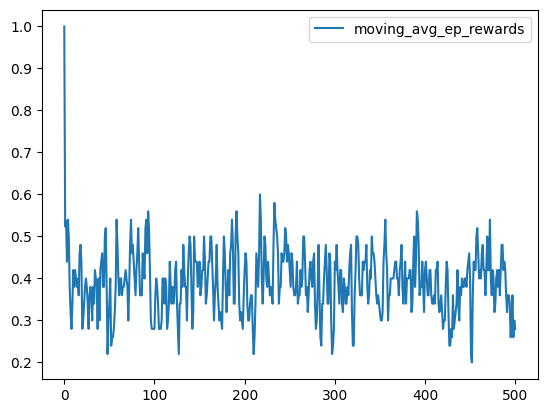

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()
size = 5
env = NTicTacToe(render_mode='rgb_array', size=size)

# Small technicality
def preprocess(state):
  return np.expand_dims(state, axis=0).astype(np.float32)

save_dir = Path("tcheckpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

Xplayer = Player(player=1, state_dim=(size, size), action_dim=env.action_space.n, save_dir=save_dir)
Oplayer = Player(player=-1, state_dim=(size, size), action_dim=env.action_space.n, save_dir=save_dir)

episodes = 10000
def train_loop(episodes, player="X"):
    model = Xplayer if player == "X" else Oplayer
    logger = MetricLogger(save_dir, player)
    step_count = 0
    for e in range(episodes):

        state, info = env.reset()
        ep_steps = 0
        # Play the game!
        state = preprocess(state)
        # Self-play
        while True:
            playing_now = info["player"]
            # Run agent on the state
            action, f = model.act(state)

            # Agent performs action
            xy = (action // size, action % size)

            next_state, reward, done, trunc, info = env.step(action)
            next_state = preprocess(next_state)

            reward *= playing_now # +1 reward whenever the model wins (either X or O)

            # if state[0][xy[0], xy[1]] != 0:
            #   print("--------Collision---------")
            #   print("Reward: ", reward)
            #   print("Game length ", ep_steps + 1)
            #   print("Winning/Losing Player ", playing_now)

            # Remember
            model.cache(state, next_state, action, reward, done)

            # Learn
            q, loss = model.learn()

            # Logging
            logger.log_step(reward, loss, q)

            # Update variables
            state = next_state
            ep_steps += 1
            step_count += 1

            # Check if end of game
            if done:
                # print("curr_reward: ", reward)
                # print("Game length ", ep_steps)
                # print("Overall Steps ", step_count)
                break

        logger.log_episode()

        if (e % 20 == 0) or (e == episodes - 1):
            logger.record(episode=e, epsilon=model.exp_rate, step=model.curr_step)

train_loop(episodes, "X")
# train_loop(episodes, "O")

In [ ]:
# @title Deprec
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()
size = 12
env = NTicTacToe(render_mode='rgb_array', size=size)

# Small technicality
def preprocess(state):
  return np.expand_dims(state, axis=0).astype(np.float32)

save_dir = Path("new_checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

Xplayer = Player(player=1, state_dim=(size, size), action_dim=env.action_space.n, save_dir=save_dir)
Oplayer = Player(player=-1, state_dim=(size, size), action_dim=env.action_space.n, save_dir=save_dir)

Xlogger = MetricLogger(save_dir, "X")
Ologger = MetricLogger(save_dir, "O")

step_count = 0
episodes = 500
for e in range(episodes):

    state, info = env.reset()
    # Small technicality

    prev_action = None
    prev_state = None
    # Play the game!
    state = preprocess(state)
    while True:
        # Run agent on the state
        curr_player = info["player"]
        action = Xplayer.act(state) if curr_player == 1 else Oplayer.act(state)
        xy = (action // size, action % size)
        while state[0][xy[0], xy[1]] != 0:
          action = Xplayer.act(state) if curr_player == 1 else Oplayer.act(state)
          xy = (action // size, action % size)
        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)
        next_state = preprocess(next_state)

        X_reward = reward
        O_reward = -X_reward
        # Remember
        if curr_player == 1:
          Xplayer.cache(state, next_state, action, X_reward, done)
          if prev_state is not None and prev_action is not None:
            Oplayer.cache(prev_state, state, prev_action, O_reward, done)
        elif curr_player == -1:
          Oplayer.cache(state, next_state, action, X_reward, done)
          if prev_state is not None and prev_action is not None:
            Xplayer.cache(prev_state, state, prev_action, O_reward, done)

        # Learn
        q_x, loss_x = Xplayer.learn()
        q_o, loss_o = Oplayer.learn()

        # Logging
        Xlogger.log_step(X_reward, loss_x, q_x)
        Ologger.log_step(O_reward, loss_o, q_o)

        # Update variables
        prev_action = action
        prev_state = state
        state = next_state
        step_count += 1
        # Check if end of game
        if (step_count % 100 == 0):
          print("X_reward ", X_reward)
          print("Step ", step_count)
        if done:
            break

    Xlogger.log_episode()
    Ologger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        Xlogger.record(episode=e, epsilon=Xplayer.exp_rate, step=Xplayer.curr_step)
        Ologger.record(episode=e, epsilon=Oplayer.exp_rate, step=Oplayer.curr_step)

In [ ]:
from IPython import display as ipythondisplay
from PIL import Image

def test_env(k: int=1):
  env = NTicTacToe(render_mode='rgb_array', size=5)
  state, info = env.reset()
  screen = env.render()
  images = [Image.fromarray(screen)]
  terminated = False
  i=0
  while not terminated:
      curr_player = info["player"]
      action, fn = Xplayer.act(state)
      # while observation[action[0], action[1]] != 0:
      #   action = env.action_space.sample()
      state, reward, terminated, truncated, info = env.step(action)

      print(action // size, action % size)
      # Render screen every k steps
      if i % k == 0:
        screen = env.render()
        images.append(Image.fromarray(screen))
      if terminated or truncated:
          print(f'observation \n{state}')
          observation, info = env.reset()

      if terminated:
        print("DONE ", i)
        print("reward: ", reward)

        break
      i+=1

  env.close()

  return images

# Save GIF image
images = test_env()
image_file = 'test.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:],  duration=1)

2 0
1 4
4 0
0 2
4 2
3 1
2 2
3 4
2 4
3 0
3 3
0 0
1 0
3 2
1 1
2 3
1 2
0 4
4 4
1 3
0 1
4 3
0 3
4 1
2 1
observation 
[[-1  1 -1  1 -1]
 [ 1  1  1 -1 -1]
 [ 1  1  1 -1  1]
 [-1 -1 -1  1 -1]
 [ 1 -1  1 -1  1]]
DONE  24
reward:  0
